In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from os import listdir
import cv2
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import random
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#cd /content/drive/MyDrive/Colab Notebooks/NienLuanNganh

/content/drive/MyDrive/Colab Notebooks/NienLuanNganh


In [ ]:
raw_folder = "./data/"
def save_data(raw_folder=raw_folder):
    print("Bắt đầu xử lý ảnh...")

    pixels = []
    labels = []

    # Lặp qua các folder con trong thư mục raw
    for folder in listdir(raw_folder):
        if folder!='.DS_Store':
            print("Folder=",folder)
            # Lặp qua các file trong từng thư mục chứa các em
            for file in listdir(raw_folder  + folder):
                if file!='.DS_Store':
                    print("File=", file)
                    pixels.append( cv2.resize(cv2.imread(raw_folder  + folder +"/" + file),dsize=(224,224)))
                    labels.append( folder)

    pixels = np.array(pixels)
    labels = np.array(labels)#.reshape(-1,1)

    from sklearn.preprocessing import LabelBinarizer
    encoder = LabelBinarizer()
    labels = encoder.fit_transform(labels)
    print(labels)

    file = open('moneydata.data', 'wb')
    # dump information to that file
    pickle.dump((pixels,labels), file)
    # close the file
    file.close()

    return

In [ ]:
#save_data()

In [ ]:
def load_data():
    file = open('./moneydata.data', 'rb')

    # dump information to that file
    (pixels, labels) = pickle.load(file)

    # close the file
    file.close()

    print(pixels.shape)
    print(labels.shape)

    return pixels, labels

In [ ]:
X,y = load_data()

(6000, 224, 224, 3)
(6000, 6)


In [ ]:
# Chia tập dữ liệu gồm tập train và tập validation dùng để kiểm tra độ chính xác lúc huấn luyện
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=100)

In [ ]:
X_val.shape

(1200, 224, 224, 3)

In [ ]:
# Load model VGG16
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# Mô hình mạng ban đầu
model_vgg16_conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
# Dong bang cac layer
for layer in model_vgg16_conv.layers:
  layer.trainable = False

In [ ]:
# Mô hình mạng khi đã đóng băng các layer
model_vgg16_conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
# Tao model
input = Input(shape=(224,224,3), name='image_input')
output_vgg16_conv = model_vgg16_conv(input)

# Them cac layer FC va Dropout
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dropout(0.3)(x)

x = Dense(6, activation='softmax', name='predictions')(x)

# Compile
vggmodel = Model(inputs=input, outputs=x)
vggmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Mô hình mạng khi thêm một số tầng
vggmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 fc1 (Dense)                 (None, 4096)              102764544 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 fc2 (Dense)                 (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0     

In [ ]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.1,
                         rescale=1./255,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         horizontal_flip=True,
                         brightness_range=[0.2,1.5], 
                         fill_mode="nearest")

In [ ]:
# Kiểm tra qua trình huấn luyện và lưu lại mô hình đạt kết quả tốt nhất
filepath = "final_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Huấn luyện với 5 lần huấn luyện
vgghist=vggmodel.fit_generator(aug.flow(X_train, y_train, batch_size=64),
                               epochs=5,
                               steps_per_epoch=len(X_train)//64,
                               validation_data=aug.flow(X_val,y_val, batch_size=64),
                               callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/5
75/75 [==============================] - ETA: 0s - loss: 3.9638 - accuracy: 0.5098
Epoch 00001: val_accuracy improved from -inf to 0.83333, saving model to final_model.h5
75/75 [==============================] - 143s 2s/step - loss: 3.9638 - accuracy: 0.5098 - val_loss: 0.4115 - val_accuracy: 0.8333
Epoch 2/5
75/75 [==============================] - ETA: 0s - loss: 0.3267 - accuracy: 0.8800
Epoch 00002: val_accuracy improved from 0.83333 to 0.96833, saving model to final_model.h5
75/75 [==============================] - 122s 2s/step - loss: 0.3267 - accuracy: 0.8800 - val_loss: 0.1083 - val_accuracy: 0.9683
Epoch 3/5
75/75 [==============================] - ETA: 0s - loss: 0.2497 - accuracy: 0.9060
Epoch 00003: val_accuracy improved from 0.96833 to 0.97000, saving model to final_model.h5
75/75 [==============================] - 123s 2s/step - loss: 0.2497 - accuracy: 0.9060 - val_loss: 0.0997 - val_accuracy: 0.9700
Epoch 4/5
75/75 [==============================] - ETA: 0s - 

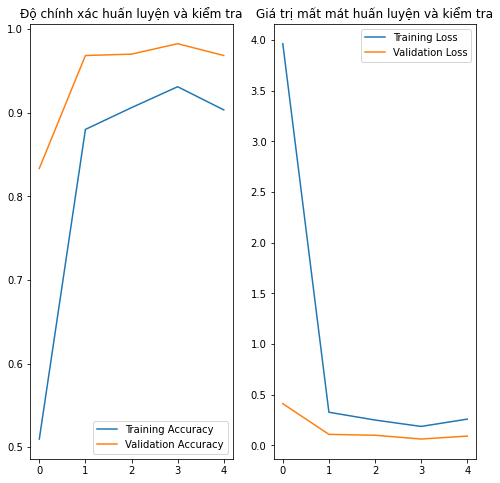

In [ ]:
# Vẽ biểu đồ thể hiện quá trình huấn luyện
acc = vgghist.history['accuracy']
val_acc = vgghist.history['val_accuracy']

loss = vgghist.history['loss']
val_loss = vgghist.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Độ chính xác huấn luyện và kiểm tra')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Giá trị mất mát huấn luyện và kiểm tra')
plt.show()